In [23]:
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib import cm
import seaborn as sns
import glob
import pickle
from collections import defaultdict
from Bio.Seq import Seq

## Load GC trees

In [2]:
results = "../nextflow/results/latest"

In [3]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)

trees = {}
for file in files:
    key = "_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file)))
    # if not any(key.split("_")[0] == f"mouse{i}" for i in range(1, 7)):
    #     print(f"skipping {key}")
    #     continue
    assert key not in trees, key
    trees[key] = pickle.load(open(file, "rb"))

    
#     trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
#          for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 95 GC trees


## 5mer mutability model

In [6]:
mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igh_frame = 1
igk_frame = 1
igk_idx = 336

def mutate_uniform(sequence):
    i = np.random.choice(len(sequence))
    base = sequence[i]
    alt_base = np.random.choice(list("ACGT".replace(base, "")))
    sequence = list(sequence)
    sequence[i] = alt_base
    return "".join(sequence)

def mutate_S5F(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

def mutations(naive_aa, aa, pos_map, chain_annotation):
    return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
            for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
            if aa1 != aa2]

naive_igh_aa = aa(naive[:igk_idx], igh_frame)
naive_igk_aa = aa(naive[igk_idx:], igk_frame)

## DMS data

In [7]:
dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,expr,delta_expr,n_bc_expr,n_libs_expr,psr,delta_psr,n_bc_psr,n_libs_psr,WT,site
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,10.48829,...,10.44614,-0.00453,19.0,2.0,6.78608,-0.07452,17.0,2.0,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,10.44477,...,10.32364,-0.12703,20.0,2.0,7.44234,0.58174,17.0,2.0,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,10.42771,...,10.51618,0.06551,16.0,2.0,6.95940,0.09880,13.0,2.0,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,10.45719,...,10.45067,0.00000,21170.0,2.0,6.86060,0.00000,18910.0,2.0,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,10.51899,...,10.33163,-0.11904,24.0,2.0,6.91372,0.05313,21.0,2.0,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,10.44756,...,10.54313,0.09246,39.0,2.0,6.93925,0.07866,33.0,2.0,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,10.43023,...,10.53860,0.08793,36.0,2.0,6.88956,0.02896,34.0,2.0,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,10.38231,...,10.48707,0.03640,27.0,2.0,6.78160,-0.07899,24.0,2.0,False,L-128


In [8]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [10]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Simulate expression-matched trees

This cell takes a while (~1 hour)

In [11]:
sim_trees = defaultdict(list)
expression_threshold = 0.2
n_replicates = 20
for gc, tree in trees.items():
    replicate = 1
    dead = False
    while replicate <= n_replicates:
        print(f"GC {gc} replicate {replicate}", end="   \r")
        new_tree = tree.tree.copy()
        for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
            assert node.name == node_new.name
            if not node.is_root():
                success = False
                closest = np.inf
                for tries in range(100):
                    node_new.sequence = node_new.up.sequence
                    for _ in range(int(node.dist)):
                        node_new.sequence = mutate_S5F(node_new.sequence)
                        igh_aa = aa(node_new.sequence[:igk_idx], igh_frame)
                        igk_aa = aa(node_new.sequence[igk_idx:], igk_frame)
                        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
                        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")        
                        all_mutations = igh_mutations + igk_mutations
                        if any("*" in x for x in all_mutations):
                            node_new.delta_bind_CGG_FVS_additive = None
                            node_new.delta_expr_FVS_additive = None
                        else:
                            node_new.delta_bind_CGG_FVS_additive = dms_df.delta_bind_CGG[all_mutations].sum()
                            node_new.delta_expr_FVS_additive = dms_df.delta_expr[all_mutations].sum()
                    # note: selecting on additive expression estimate
                    if node_new.delta_expr_FVS_additive is None:
                        continue
                    delta = np.abs(node_new.delta_expr_FVS_additive - node.delta_expr_FVS_additive)
                    if delta < closest:
                        closest = delta
                        closest_seq = node_new.sequence
                        delta_bind_CGG = node_new.delta_bind_CGG_FVS_additive
                        closest_delta_expr = node_new.delta_expr_FVS_additive
                    if delta < expression_threshold:
                        success = True
                        break
                if not success:
                    node_new.sequence = closest_seq
                    node_new.delta_bind_CGG_FVS_additive = delta_bind_CGG
                    node_new.delta_expr_FVS_additive = closest_delta_expr

        sim_trees[gc].append(new_tree)
        replicate += 1

In [12]:
sim_df = pd.DataFrame()
expression_thresh = -1
replicate = 1
while replicate < 1000:
    print(f"replicate {replicate + 1}", end="   \r")
    sequence = naive
    n_mutations = 0
    rows = []
    while n_mutations <= 20:
        if n_mutations:
            new_sequence = mutate_S5F(sequence)
        else:
            new_sequence = sequence
        igh_aa = aa(new_sequence[:igk_idx], igh_frame)
        igk_aa = aa(new_sequence[igk_idx:], igk_frame)
        igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map, "(H)")
        igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map, "(L)")
        all_mutations = igh_mutations + igk_mutations
        has_stop = any("*" in mutation for mutation in all_mutations)
        affinity = np.nan if has_stop else dms_df.delta_bind_CGG[all_mutations].sum()
        expression = np.nan if has_stop else dms_df.delta_expr[all_mutations].sum()
        if expression < expression_thresh:
            continue
        new_row = [affinity,
                   expression,
                   n_mutations,
                   replicate,
                  ]
        rows.append(new_row)
        sequence = new_sequence
        n_mutations += 1
    rep_df = pd.DataFrame(rows, columns=(r"$\Delta$ affinity", r"$\Delta$ expression", "divergence", "replicate"))
    sim_df = pd.concat((sim_df, rep_df), ignore_index=True, verify_integrity=True)
    replicate += 1
sim_df

,$\Delta$ affinity,$\Delta$ expression,divergence,replicate
0,0.00000,0.00000,0,1
1,0.83479,0.06849,1,1
2,0.83479,0.06849,2,1
3,0.83479,0.06849,3,1
4,-0.37002,-0.70462,4,1
...,...,...,...,...
20974,-2.97301,-0.82986,16,999
20975,-2.94373,-0.79322,17,999
20976,-3.03545,-0.80826,18,999
20977,-6.42514,-0.97394,19,999


In [13]:
output_dir = "output/phenotype-trajectories"

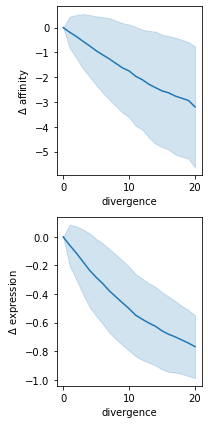

In [14]:
plt.figure(figsize=(3, 6))
plt.subplot(211)
sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ affinity",
             ci="sd",
             # units="replicate", estimator=None, lw=1, alpha=0.5,
            )
plt.subplot(212)
sns.lineplot(data=sim_df, x="divergence", y=r"$\Delta$ expression",
             ci="sd",
             # units="replicate", estimator=None, lw=1, alpha=0.5,
            )
plt.tight_layout()
plt.savefig(f"{output_dir}/S5F-Vs-uniform.pdf")
plt.show()

GVI decay factor

In [20]:
tau = 0.75

In [38]:
for tree in trees.values():
    total_abundance = sum(node.abundance for node in tree.tree.traverse())
    for node in tree.tree.traverse():
        node.GVI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance

for tree_reps in sim_trees.values():
    for tree in tree_reps:
        total_abundance = sum(node.abundance for node in tree.traverse())
        for node in tree.traverse():
            node.GVI = sum(node2.abundance * tau ** node2.get_distance(node) for node2 in node.traverse()) / total_abundance

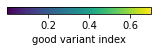

In [24]:
vmin = min(node.GVI for tree in trees.values() for node in tree.tree.traverse())
vmax = max(node.GVI for tree in trees.values() for node in tree.tree.traverse())
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = "viridis"

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
             orientation='horizontal',
             cax=cax,
             label="good variant index")
plt.savefig(f"{output_dir}/cbar.pdf", bbox_inches="tight")
plt.show()

**Note:** lower bounding phenotypes according to worst single mutant

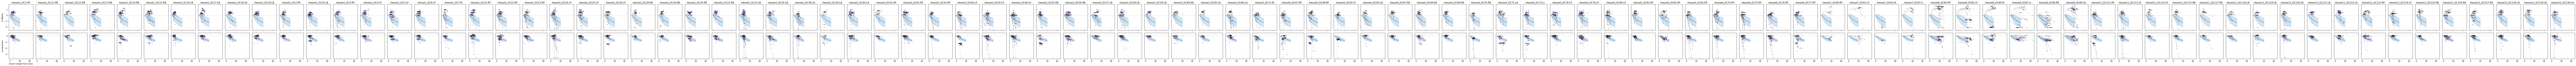

In [59]:
worst_bind = dms_df.delta_bind_CGG.min() #np.nanmin([node.delta_bind_CGG_FVS_additive for tree in trees.values() for node in tree.tree.traverse()]) - .1
worst_expr = dms_df.delta_expr.min() # np.nanmin([node.delta_expr_FVS_additive for tree in trees.values() for node in tree.tree.traverse()]) - .1

sim_df_clipped = sim_df.copy()
sim_df_clipped[r"$\Delta$ affinity"].clip(lower=worst_bind, inplace=True)
sim_df_clipped[r"$\Delta$ expression"].clip(lower=worst_expr, inplace=True)

fig, axes = plt.subplots(2, len(trees), figsize=(2 * len(trees), 5), sharex=True, sharey="row")

for i, (phenotype, phenotype_label, worst_phenotype) in enumerate(zip(("delta_bind_CGG_FVS_additive", "delta_expr_FVS_additive"
                                                      ),
                                                     (r"$\Delta$ affinity", r"$\Delta$ expression"
                                                      ),
                                                     (worst_bind, worst_expr)
                                                     )):
    for j, (gc, tree) in enumerate(trees.items()):

        #  only 20-day
        # if not int(gc.split("_")[0].lstrip("mouse")) in range(1, 6 + 1):
        #     continue

        points = []
        lines = []
        colors = []
        
#         if j == 4: break
        
        for node in tree.tree.traverse():
            node_phenotype = getattr(node, phenotype)
            if node_phenotype < worst_phenotype:
                node_phenotype = worst_phenotype
            elif np.isnan(node_phenotype):
                node_phenotype = worst_phenotype - .5
            points.append((tree.tree.get_distance(node),
                           node_phenotype,
                           1 + 5 * node.abundance,
                           node.GVI))
            if node.up is not None:
                parent_phenotype = getattr(node.up, phenotype)
                if parent_phenotype < worst_phenotype:
                    parent_phenotype = worst_phenotype
                elif np.isnan(parent_phenotype):
                    parent_phenotype = worst_phenotype - .5
                lines.append([(tree.tree.get_distance(node.up), parent_phenotype),
                              (tree.tree.get_distance(node), node_phenotype)])
            colors.append(node.GVI)

        # sim_lines = []
        # for sim_idx, sim_tree in enumerate(sim_trees[gc]):
        #     for node in sim_tree.traverse():
        #         if node.up is not None:
        #             sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
        #                               (sim_tree.get_distance(node), getattr(node, phenotype))])
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        # sim_lc = mc.LineCollection(sim_lines, colors="C0", linewidths=1, alpha=0.1, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
        ax.axhline(worst_phenotype, c="orange", ls="--", lw=0.25, zorder=1)
        ax.axhline(worst_phenotype - 0.5, c="r", ls="--", lw=0.25, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        # ax.add_collection(sim_lc)
        sns.lineplot(data=sim_df_clipped, x="divergence", y=r"$\Delta$ affinity" if i == 0 else r"$\Delta$ expression", ci="sd", ax=ax, legend=False)
        ax.scatter(*zip(*points), cmap=cmap, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4,
                   norm=norm)   
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig(f"{output_dir}/phenotype-trajectories.pdf")
plt.show()

In [39]:
def tree_stats(tree):
    affinity_dat = []
    expression_dat = []
    cells_sampled = 0
    gvi_dat = []
    for node in tree.traverse():
        cells_sampled += node.abundance
        for _ in range(node.abundance):
            affinity_dat.append(node.delta_bind_CGG_FVS_additive)
            expression_dat.append(node.delta_expr_FVS_additive)
            gvi_dat.append(node.GVI)
    return cells_sampled, np.nanmedian(affinity_dat), np.nanmedian(expression_dat), np.nanmax(gvi_dat)

dat = []
for mousegc, tree in trees.items():
    mouse, gc = mousegc.split("_")
    mouse = int(mouse.lstrip("mouse"))
    if mouse in (1, 2, 3, 4, 5, 6):
        mouse_type = "20-day"
    elif mouse in (7, 8):
        mouse_type = "10-week"
    elif mouse in (11, 12):
        mouse_type = "LMP2A"
    else:
        raise ValueError()
    gc = gc.lstrip("GC")
    dat.append([mouse, mouse_type, gc, "real", *tree_stats(tree.tree)])
    for rep_tree in sim_trees[mousegc]:
        dat.append([mouse, mouse_type, gc, "simulated", *tree_stats(rep_tree)])

stat_df = pd.DataFrame(dat, columns=["mouse", "mouse type", "germinal center", "data type", "cells sampled", r"median $\Delta$ affinity", r"median $\Delta$ expression", "max GVI"])
# stat_df.set_index(["mouse", "germinal center"], inplace=True)
stat_df

,mouse,mouse type,germinal center,data type,cells sampled,median $\Delta$ affinity,median $\Delta$ expression,max GVI
0,1,20-day,1-RP,real,89,1.124685,-0.159660,0.150701
1,1,20-day,1-RP,simulated,89,-0.032330,-0.107590,0.150701
2,1,20-day,1-RP,simulated,89,-0.185070,-0.139950,0.150701
3,1,20-day,1-RP,simulated,89,-0.159240,-0.124470,0.150701
4,1,20-day,1-RP,simulated,89,-0.740980,-0.137860,0.150701
...,...,...,...,...,...,...,...,...
1990,12,LMP2A,130-LA,simulated,64,-0.220530,-0.154330,0.215058
1991,12,LMP2A,130-LA,simulated,64,-0.514520,-0.157550,0.215058
1992,12,LMP2A,130-LA,simulated,64,-0.123330,-0.073865,0.215058
1993,12,LMP2A,130-LA,simulated,64,-0.316250,-0.130695,0.215058


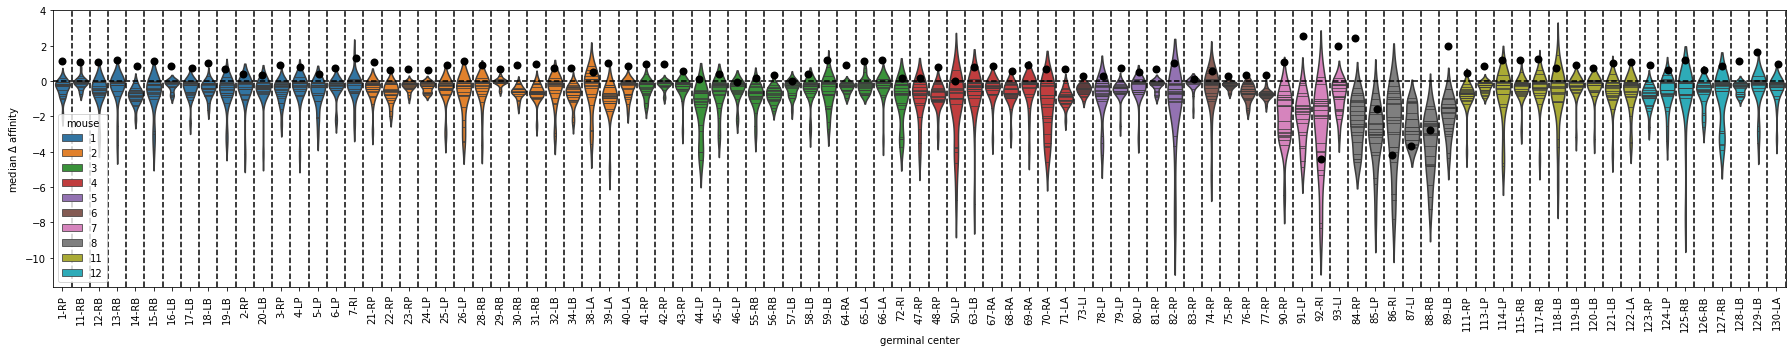

In [40]:
plt.figure(figsize=(25, 5))
g = sns.violinplot(data=stat_df.query("`data type` == 'simulated'"),
                x="germinal center", y=r"median $\Delta$ affinity", hue="mouse",
                inner="stick", dodge=False
               )
sns.stripplot(data=stat_df.query("`data type` == 'real'"),
              x="germinal center", y=r"median $\Delta$ affinity",
              color="k", size=8)
for item in g.get_xticklabels():
    item.set_rotation(90)
for tick_pos in g.get_xticks():
    plt.axvline(tick_pos + 0.5, c="k", ls="--")
plt.axhline(0, c="k", ls="--")
plt.tight_layout()
plt.savefig(f"{output_dir}/selection.pdf")
plt.show()

# sns.displot(data=stat_df, col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4)
# sns.displot(data=stat_df.loc[stat_df.simulation == False], col="GC", x=fr"GC fraction with $\Delta\log_{{10}}K_a>{threshold}$", hue="simulation type", col_wrap=4, rug=True)
# # plt.savefig(f"{plot_dir}/selection_stat.pdf")
# plt.show()

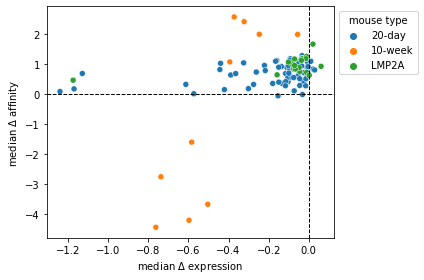

In [41]:
plt.figure(figsize=(6, 4))
g = sns.scatterplot(data=stat_df.loc[stat_df["data type"] == "real"],
                x=r"median $\Delta$ expression", y=r"median $\Delta$ affinity", hue="mouse type",
                # size="cells sampled"
                   )
plt.axhline(0, ls="--", c="k", lw=1)
plt.axvline(0, ls="--", c="k", lw=1)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{output_dir}/median-phenotypes.pdf")
plt.show()

In [42]:
rows = []
for gc, group in stat_df.groupby("germinal center"):
    mouse, mouse_type, true_affinity, expression, n_cells, max_gvi = group.query("`data type` == 'real'")[["mouse", "mouse type", r"median $\Delta$ affinity", r"median $\Delta$ expression", "cells sampled", "max GVI"]].iloc[0]
    null_affinities = group.query("`data type` == 'simulated'")[r"median $\Delta$ affinity"]
    # z score for selection
    selection = (true_affinity - null_affinities.mean()) / null_affinities.std()
    rows.append([gc, mouse, mouse_type, n_cells, max_gvi, true_affinity, expression, selection])

selection_df = pd.DataFrame(data=rows, columns=("germinal center", "mouse", "mouse type", "cells sampled", "max GVI", r"median $\Delta$ affinity", r"median $\Delta$ expression", "affinity selection strength"))
selection_df

,germinal center,mouse,mouse type,cells sampled,max GVI,median $\Delta$ affinity,median $\Delta$ expression,affinity selection strength
0,1-RP,1,20-day,89,0.150701,1.124685,-0.159660,3.121067
1,11-RB,1,20-day,66,0.419667,1.065520,-0.005300,3.632747
2,111-RP,11,LMP2A,69,0.355007,0.470875,-1.175255,1.746315
3,113-LP,11,LMP2A,71,0.148565,0.867105,-0.075315,4.053775
4,114-LP,11,LMP2A,42,0.277466,1.177175,-0.070900,1.389576
...,...,...,...,...,...,...,...,...
90,89-LB,8,10-week,72,0.027778,2.000855,-0.246750,3.690045
91,90-RP,7,10-week,18,0.118056,1.078820,-0.393625,2.195687
92,91-LP,7,10-week,19,0.167262,2.577530,-0.372025,3.520165
93,92-RI,7,10-week,20,0.703125,-4.426580,-0.762780,-0.652108


/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/replay/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


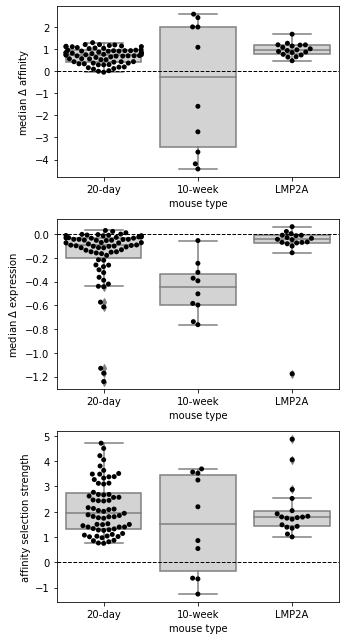

In [43]:
order = ("20-day", "10-week", "LMP2A")

plt.figure(figsize=(5, 9))

plt.subplot(311)
g = sns.boxplot(data=selection_df, x="mouse type", y=r"median $\Delta$ affinity", color="lightgrey", order=order)
g = sns.swarmplot(data=selection_df, x="mouse type", y=r"median $\Delta$ affinity", color="k", order=order)
plt.axhline(0, ls="--", c="k", lw=1)

plt.subplot(312)
g = sns.boxplot(data=selection_df, x="mouse type", y=r"median $\Delta$ expression", color="lightgrey", order=order)
g = sns.swarmplot(data=selection_df, x="mouse type", y=r"median $\Delta$ expression", color="k", order=order)
plt.axhline(0, ls="--", c="k", lw=1)

plt.subplot(313)
g = sns.boxplot(data=selection_df, x="mouse type", y="affinity selection strength", color="lightgrey", order=order)
g = sns.swarmplot(data=selection_df, x="mouse type", y="affinity selection strength", color="k", order=order)
plt.axhline(0, ls="--", c="k", lw=1)

plt.tight_layout()
plt.savefig(f"{output_dir}/selection-boxplots.pdf")
plt.show()

In [44]:
from scipy.stats import mannwhitneyu
mannwhitneyu(selection_df.query("`mouse type` == '20-day'")[r"median $\Delta$ affinity"], selection_df.query("`mouse type` == 'LMP2A'")[r"median $\Delta$ affinity"])

MannwhitneyuResult(statistic=338.0, pvalue=0.004440124079133716)

In [45]:
selection_df.groupby("mouse type").median().drop(columns="mouse")

,cells sampled,max GVI,median $\Delta$ affinity,median $\Delta$ expression,affinity selection strength
mouse type,,,,,
10-week,64.5,0.142659,-0.25636,-0.448502,1.528256
20-day,78.0,0.177873,0.74098,-0.096490,1.937423
LMP2A,71.5,0.221035,0.94725,-0.046277,1.778064


In [71]:
dat = []
for mousegc, tree in trees.items():
    mouse, gc = mousegc.split("_")
    mouse = mouse.lstrip("mouse")
    gc = gc.lstrip("GC")
    
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    dom_score = max(clade_sizes) / sum(clade_sizes)
    max_GVI = np.nanmax([node.GVI for node in tree.tree.traverse()])
    
    for node in tree.tree.traverse():
        stop_ct = node.abundance if np.isnan(node.delta_bind_CGG_FVS_additive) else 0
        if node.abundance:
            dat.append([mouse, gc, node.name, node.abundance, stop_ct, tree.tree.get_distance(node), node.delta_bind_CGG_FVS_additive, node.delta_expr_FVS_additive])

cell_df = pd.DataFrame(dat, columns=("mouse", "germinal center", "id", "cells sampled", "unproductive cells", "divergence from naive BCR", r"$\Delta$ affinity", r"$\Delta$ expression"))

cell_df[r"$\Delta$ affinity"] = cell_df[r"$\Delta$ affinity"].clip(lower=worst_bind)
cell_df[r"$\Delta$ expression"] = cell_df[r"$\Delta$ expression"].clip(lower=worst_expr)

cell_df

,mouse,germinal center,id,cells sampled,unproductive cells,divergence from naive BCR,$\Delta$ affinity,$\Delta$ expression
0,1,1-RP,seq62,1,0,4.0,-0.06082,0.14827
1,1,1-RP,seq9,1,0,11.0,-3.45668,-1.05627
2,1,1-RP,seq76,1,0,1.0,-0.80796,-0.15104
3,1,1-RP,seq17,1,0,3.0,-1.52301,-0.34882
4,1,1-RP,seq51,1,0,9.0,-4.34294,-0.81985
...,...,...,...,...,...,...,...,...
5989,12,130-LA,seq48,1,0,9.0,0.76981,-0.35360
5990,12,130-LA,seq43,1,1,6.0,NaN,NaN
5991,12,130-LA,seq40,1,0,6.0,1.21465,-0.30891
5992,12,130-LA,seq6,1,0,7.0,0.93495,0.03260


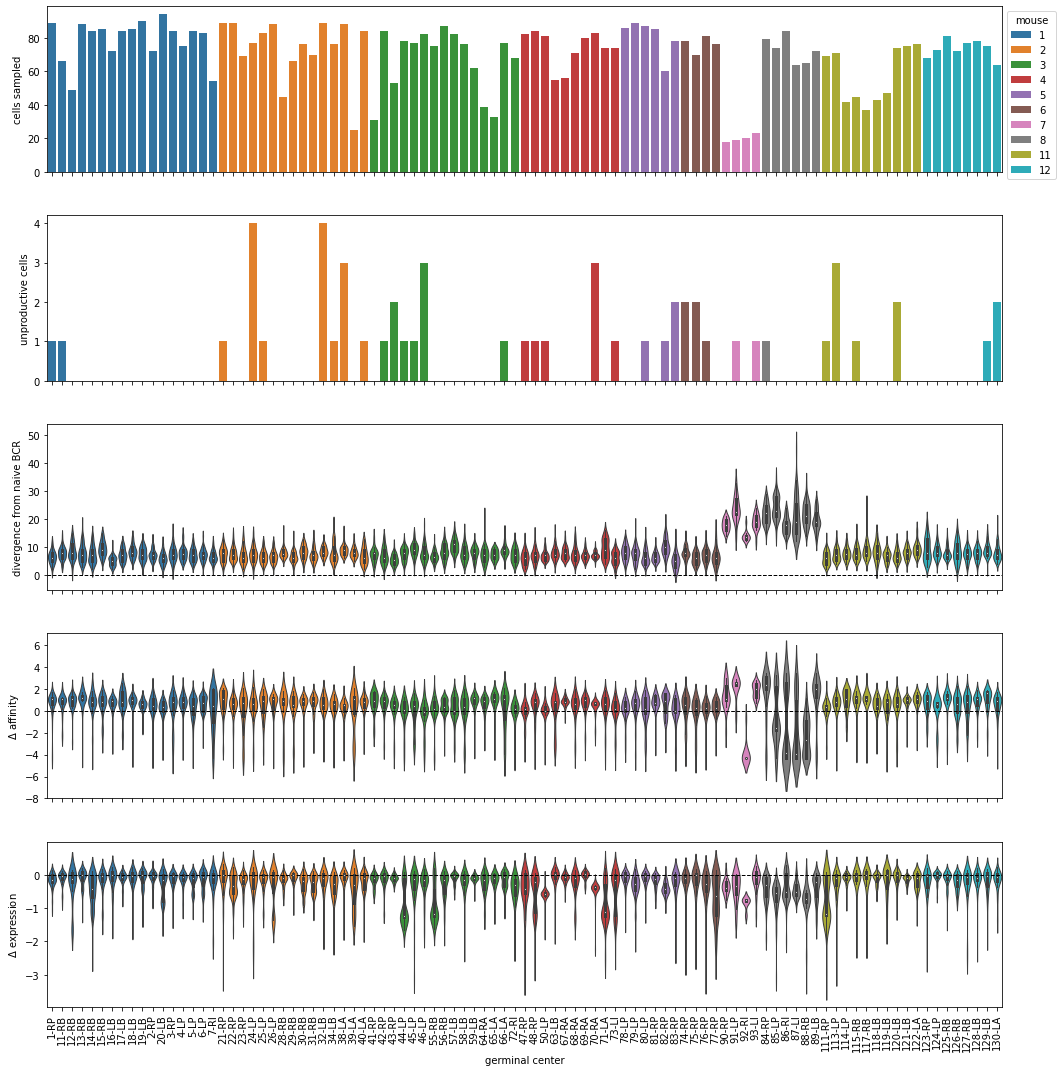

In [73]:
# order = cell_df.groupby("germinal center").agg({"mouse": "first", "cells sampled": sum}).sort_values(["mouse", "cells sampled"]).index

fig, axes = plt.subplots(5, 1, sharex="col", figsize=(15, 15))

sns.barplot(data=cell_df, x="germinal center", hue="mouse", y="cells sampled",
            ci=None, estimator=sum, dodge=False, ax=axes[0])
sns.move_legend(axes[0], "upper left")
axes[0].set(xlabel=None)
axes[0].axhline(0, ls="--", c="k", lw=1)

g = sns.barplot(data=cell_df, x="germinal center", hue="mouse", y="unproductive cells",
            ci=None, estimator=sum, dodge=False, ax=axes[1])
g.legend_.remove()
axes[1].set(xlabel=None)
axes[1].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y="divergence from naive BCR", weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[2])
axes[2].get_legend().remove()
axes[2].set(xlabel=None)
axes[2].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ affinity", weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[3])
axes[3].get_legend().remove()
axes[3].set(xlabel=None)
axes[3].axhline(0, ls="--", c="k", lw=1)

ax = sns.violinplot(data=cell_df, x="germinal center", hue="mouse", y=r"$\Delta$ expression", weights="abundance",
                    dodge=False, legend=False, linewidth=1, ax=axes[4])
axes[4].get_legend().remove()
axes[4].axhline(0, ls="--", c="k", lw=1)

sns.move_legend(axes[0], "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{output_dir}/cell-summary.pdf")
plt.show()